# 初始化

In [1]:
from alpha.notebook import *
import json

await init_notebook()

async def report(key:str, params:dict, result_df:pd.DataFrame):
    """key must be unique, contains a date"""
    await omicron.cache.sys.hmset_dict(key, params)
    
    html = f"""
    <html>
    <head>
        <style>
            table, th, td {{
                border-collapse: collapse;
                border: 0px;
                color: #666;
            }}
        </style>
    </head>
    <body>
    <h2 style="color:#c21">相似曲线</h2>
    {build_table(result_df, "grey_light")}
    </body>
    </html>
    """
    send_html_email(f"相似曲线 {key}", html)

# 华致酒行

华致酒行2021年9月15日前后通过东方财富选股器选出。可能的查询条件为：人气在前100（1000？），机构调研大于3，量比大于3，预测盈利大于50%，换手率大于3%等。

现从纯量价关系上尝试重新发现该股。

## 固化走势特征

In [2]:
sec = Security("300755.XSHE")
end = arrow.get("2021-10-08").date()
start = tf.day_shift(end, -79)
bars = await sec.load_bars(start, end, FrameType.DAY)

hzjh = []
close = bars["close"]/bars["close"][0]

for win in [5, 10, 20, 30, 60]:
    ma = moving_average(close, win)[-5:]
    hzjh.append(ma)
    
print(hzjh[0])

[0.74346477 0.74121866 0.75297495 0.75961771 0.76936682]


## 回测

回测信号发出后一周的涨跌幅

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import paired_euclidean_distances

async def scan(date:str):
    results = []
    for code in Securities().choose(["stock"]):
        sec = Security(code)
        end = arrow.get(date).date()
        start = tf.day_shift(end, -79)
        
        try:
            xbars = await sec.load_bars(start, end, FrameType.DAY)
            xclose = xbars["close"]

            if len(xclose) < 80 or np.count_nonzero(np.isfinite(xclose)) < 80 * 0.9:
                continue

            # get actual adv/dec after `date`
            ystart = tf.day_shift(end, 1)
            yend = tf.day_shift(ystart, 1)
            
            ybars = await sec.load_bars(ystart, yend, FrameType.DAY)
            if len(ybars) < 2 or np.count_nonzero(np.isfinite(ybars["close"])) < 2:
                continue

            pcr = max(ybars["close"]) / xclose[-1] - 1

            xclose = fillna(xclose.copy())
            xclose /= xclose[0]
            vecs = []
            
            for win in [5, 10, 20, 30, 60]:
                ma = moving_average(xclose, win)[-5:]
                vecs.append(ma)
            
            d = paired_euclidean_distances(vecs, hzjh)

            results.append([sec.display_name, code, d, np.var(d), pcr])
        except Exception:
            pass
        
    return pd.DataFrame(results, columns=["name", "code", "d", "variance", "pcr"])
            
df = await scan("2021-10-08")

In [4]:
df.nsmallest(10, "variance")

,name,code,d,variance,pcr
2077,华致酒行,300755.XSHE,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.209910
1024,克明食品,002661.XSHE,"[0.024689293656318504, 0.011435278493265725, 0...",0.000025,0.007957
3449,今世缘,603369.XSHG,"[0.13494120425716086, 0.13036611080705465, 0.1...",0.000032,0.016978
3507,普莱柯,603566.XSHG,"[0.027654388568145852, 0.009963868714544263, 0...",0.000126,-0.001015
992,金达威,002626.XSHE,"[0.05749549855478782, 0.03327052949655425, 0.0...",0.000128,0.017764
577,创新医疗,002173.XSHE,"[0.37886950831983013, 0.3969956562880026, 0.38...",0.000142,0.010219
1602,卫宁健康,300253.XSHE,"[0.41350305021821987, 0.4191130442153619, 0.43...",0.000160,-0.008953
1285,西麦食品,002956.XSHE,"[0.10443130778719922, 0.10573222921940609, 0.1...",0.000166,-0.010599
2452,创兴资源,600193.XSHG,"[0.33858315521050647, 0.35621420835811085, 0.3...",0.000179,-0.034913
3259,爱普股份,603020.XSHG,"[0.036838403526786447, 0.03746059362877973, 0....",0.000186,0.037940


In [5]:
async def parallel_show(code1, frame1, code2, frame2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    codes = [code1, code2]
    frames = [frame1, frame2]
    
    for i in range(2):
        ax = axes[i]
        code = codes[i]
        frame = frames[i]
        
        end = arrow.get(frame).date()
        start = tf.day_shift(end, -79)
        
        bars = await Security(code).load_bars(start, end, FrameType.DAY)
        close = bars["close"].copy()

        close /= close[0]
    
        ax.text(0, 0.95, f"{code} {frame}", transform=ax.transAxes)
        for win in [5, 10, 20, 30, 60]:
            ma = moving_average(close, win)
            ax.plot(ma[-20:])
            ax.text(19, ma[-1], f"{win}")

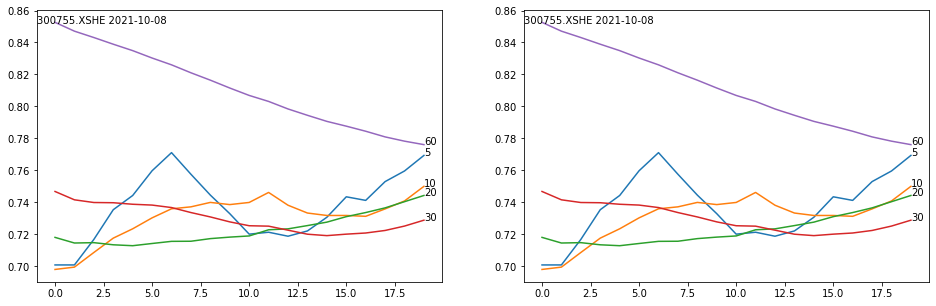

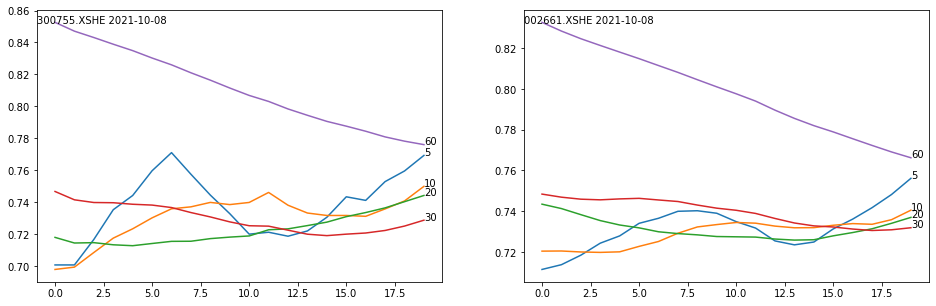

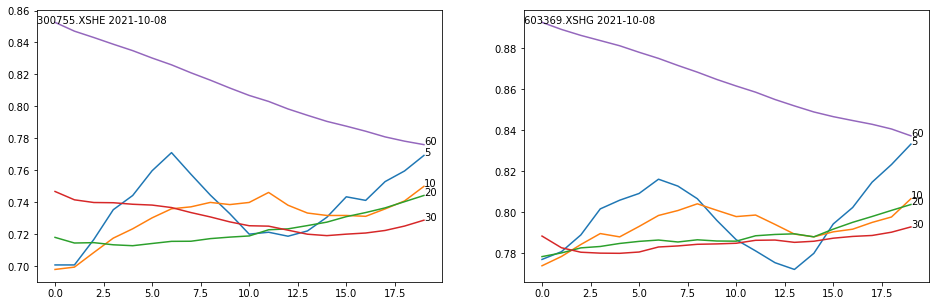

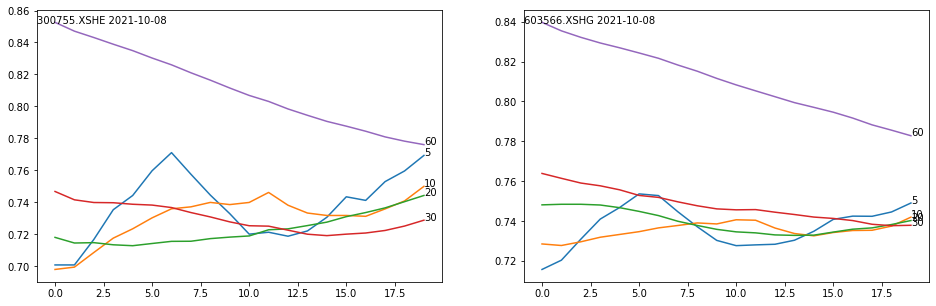

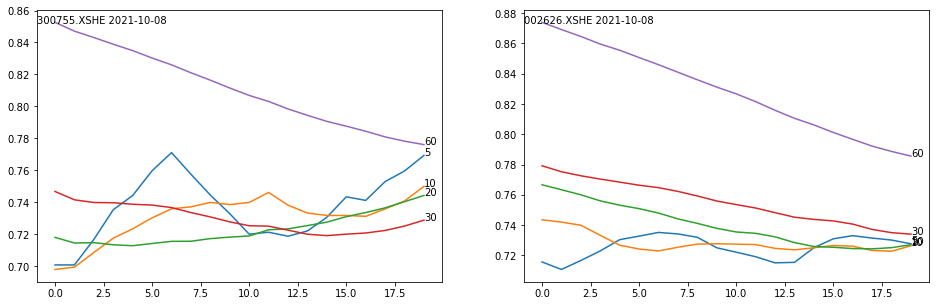

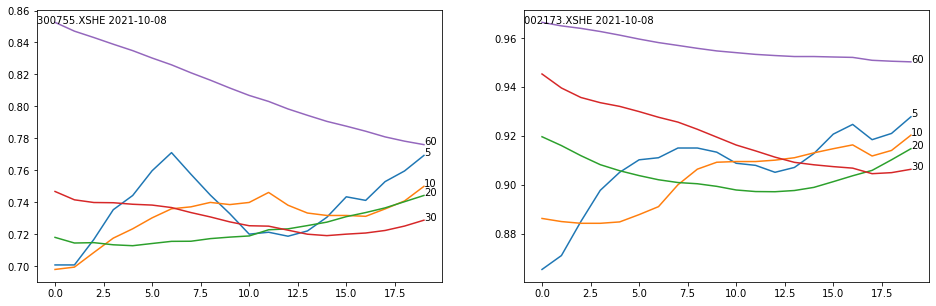

2021-10-12 15:04:15,111 W 93866 matplotlib.text:draw:688 | posx and posy should be finite values
2021-10-12 15:04:15,151 W 93866 matplotlib.text:draw:688 | posx and posy should be finite values


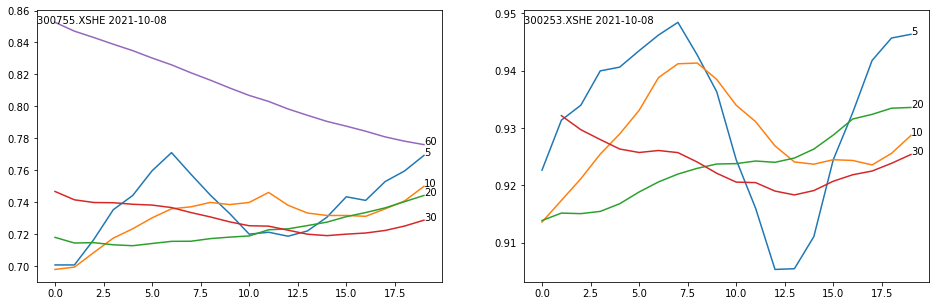

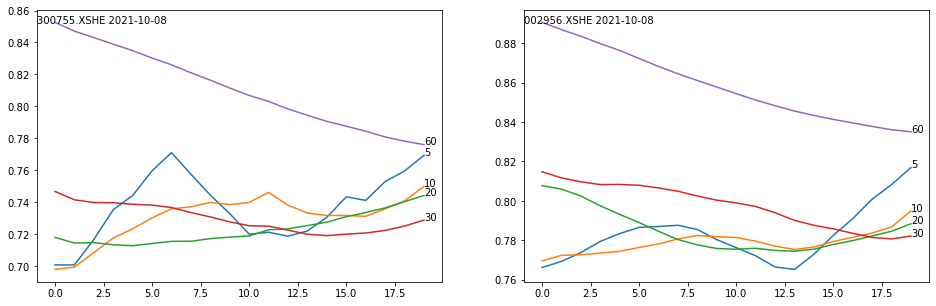

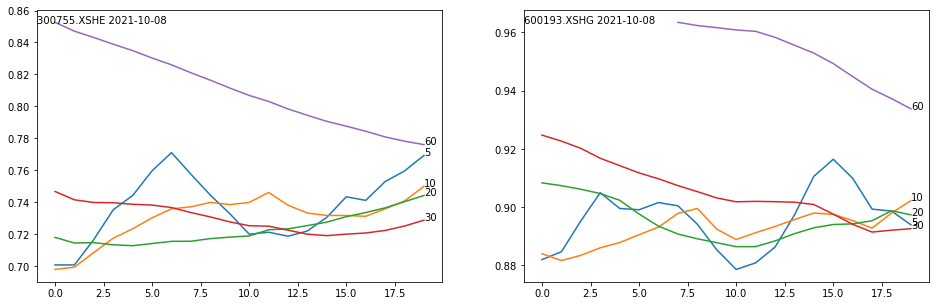

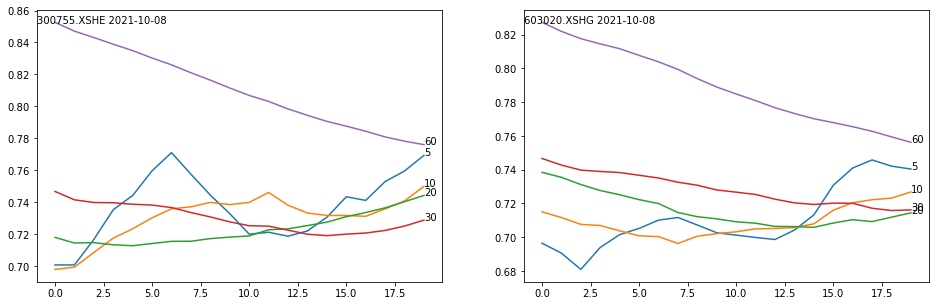

In [6]:
df = df.nsmallest(10, "variance")
for row in df.to_records():
    code = row["code"]
    await parallel_show("300755.XSHE", "2021-10-08", code, "2021-10-08")